# Tutorial 2: Deep MLPs

**Week 1, Day 3: Multi Layer Perceptrons**

**By Neuromatch Academy**

__Content creators:__ Arash Ash, Surya Ganguli

__Content reviewers:__ Saeed Salehi, Felix Bartsch, Yu-Fang Yang, Melvin Selim Atay, Kelson Shilling-Scrivo

__Content editors:__ Gagana B, Kelson Shilling-Scrivo, Spiros Chavlis

__Production editors:__ Anoop Kulkarni, Kelson Shilling-Scrivo, Gagana B, Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives
In this tutorial, we will dive deeper into MLPs and see more of their mathematical and practical aspects. Today we are going to see why MLPs:
* Can be deep or wide
* Dependant on transfer functions
* Sensitive to initialization

In [ ]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/ed65b/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for all videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/ed65b/download).

---
# Setup
This is a GPU free notebook!

In [1]:
# @title Install dependencies
!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

atform = AirtableForm('appn7VdPRseSoMXEG','W1D3_T2','https://portal.neuromatchacademy.org/api/redirect/to/3c25f915-2a3c-4c6c-8200-3084c0de1924')

In [2]:
# Imports
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

In [3]:
# @title Figure Settings
import ipywidgets as widgets       # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")
my_layout = widgets.Layout()

In [4]:
# @title Helper functions (MLP Tutorial 1 Codes)

# @markdown `Net(nn.Module)`

class Net(nn.Module):
  """
  Simulate MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: int
        Number of units in the hidden layer
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshapinng later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one
      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module(f"Linear_{i}", layer) # Append layer to the model with a name

      actv_layer = eval(f"nn.{actv}") # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module(f"Activation_{i}", actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # forward pass of MLP
    return logits


# @markdown `train_test_classification(net, criterion, optimizer, train_loader, test_loader, num_epochs=1, verbose=True, training_plot=False)`
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: Instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.to(device)
  net.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
        Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')
    print(f'Accuracy on the {test_total} testing samples: {test_acc:0.2f}\n')

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc


# @markdown `shuffle_and_split_data(X, y, seed)`
def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Set seed for reproducibility
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(0.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

In [5]:
# @title Plotting functions
def imshow(img):
  """
  Helper function to plot unnormalised image

  Args:
    img: torch.tensor
      Image to be displayed

  Returns:
    Nothing
  """
  img = img / 2 + 0.5     # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()


def sample_grid(M=500, x_max=2.0):
  """
  Helper function to simulate sample meshgrid

  Args:
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points

  Returns:
    X_all: torch.tensor
      Concatenated meshgrid tensor
  """
  ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max,M),
                          torch.linspace(-x_max, x_max, M))
  X_all = torch.cat([ii.unsqueeze(-1),
                     jj.unsqueeze(-1)],
                     dim=-1).view(-1, 2)
  return X_all


def plot_decision_map(X_all, y_pred, X_test, y_test,
                      M=500, x_max=2.0, eps=1e-3):
  """
  Helper function to plot decision map

  Args:
    X_all: torch.tensor
      Concatenated meshgrid tensor
    y_pred: torch.tensor
      Labels predicted by the network
    X_test: torch.tensor
      Test data
    y_test: torch.tensor
      Labels of the test data
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points
    eps: float
      Decision threshold

  Returns:
    Nothing
  """
  decision_map = torch.argmax(y_pred, dim=1)

  for i in range(len(X_test)):
    indeces = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps    # [TO-DO]
    decision_map[indeces] = (K + y_test[i]).long()

  decision_map = decision_map.view(M, M).cpu()
  plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
  plt.plot()

In [6]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [8]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [9]:
# @title Download of the Animal Faces dataset
# @markdown Animal faces consists of 16,130 32x32 images belonging to 3 classes
import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `AnimalFaces` dataset...")
name = 'AnimalFaces32x32'
fname = f"{name}.zip"
url = f"https://osf.io/kgfvj/download"
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content)

with ZipFile(fname, 'r') as zfile:
  zfile.extractall(f"./{name}")

if os.path.exists(fname):
  os.remove(fname)
else:
  print(f"The file {fname} does not exist")

os.chdir(name)
print("Download completed.")

Start downloading and unzipping `AnimalFaces` dataset...
Download completed.


In [10]:
# @title Data Loader
# @markdown Execute this cell!
K = 4
sigma = 0.4
N = 1000
t = torch.linspace(0, 1, N)
X = torch.zeros(K*N, 2)
y = torch.zeros(K*N)
for k in range(K):
  X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))   # [TO-DO]
  X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))   # [TO-DO]
  y[k*N:(k+1)*N] = k


X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y, seed=SEED)

# DataLoader with random seed
batch_size = 128
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                         )

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )

---
# Section 1: Wider vs deeper networks

*Time estimate: ~45 mins*

In [11]:
# @title Video 1: Deep Expressivity
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV19f4y157vG", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"g8JuGrNk9ag", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 1: Deep Expressivity')

display(out)

## Coding Exercise 1: Wide vs. Deep while keeping number of parameters same
Let's find the optimal number of hidden layers under a fixed number of parameters constraint!
But first, we need a model parameter counter. You could iterate over the model layers by calling `.parameters()` and then use `.numel()` to count the layer parameters. Also, you can use [`requires_grad`](https://pytorch.org/docs/stable/notes/autograd.html) attribute to make sure it's a trainable parameter. E.g.,
```python
x = torch.ones(10, 5, requires_grad=True)
```
After defining the counter function, we will step by step increase the depth and then iterate over the possible number of hidden units (assuming same for all hidden layers); then using our parameter counter choose the number of hidden units that results in overall close to `max_par_count` parameters.

Random seed 2021 has been set.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 80.81
Accuracy on the 800 testing samples: 80.25



  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 85.28
Accuracy on the 800 testing samples: 85.50



  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 91.66
Accuracy on the 800 testing samples: 91.38



  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 87.78
Accuracy on the 800 testing samples: 85.62



  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 80.28
Accuracy on the 800 testing samples: 79.38



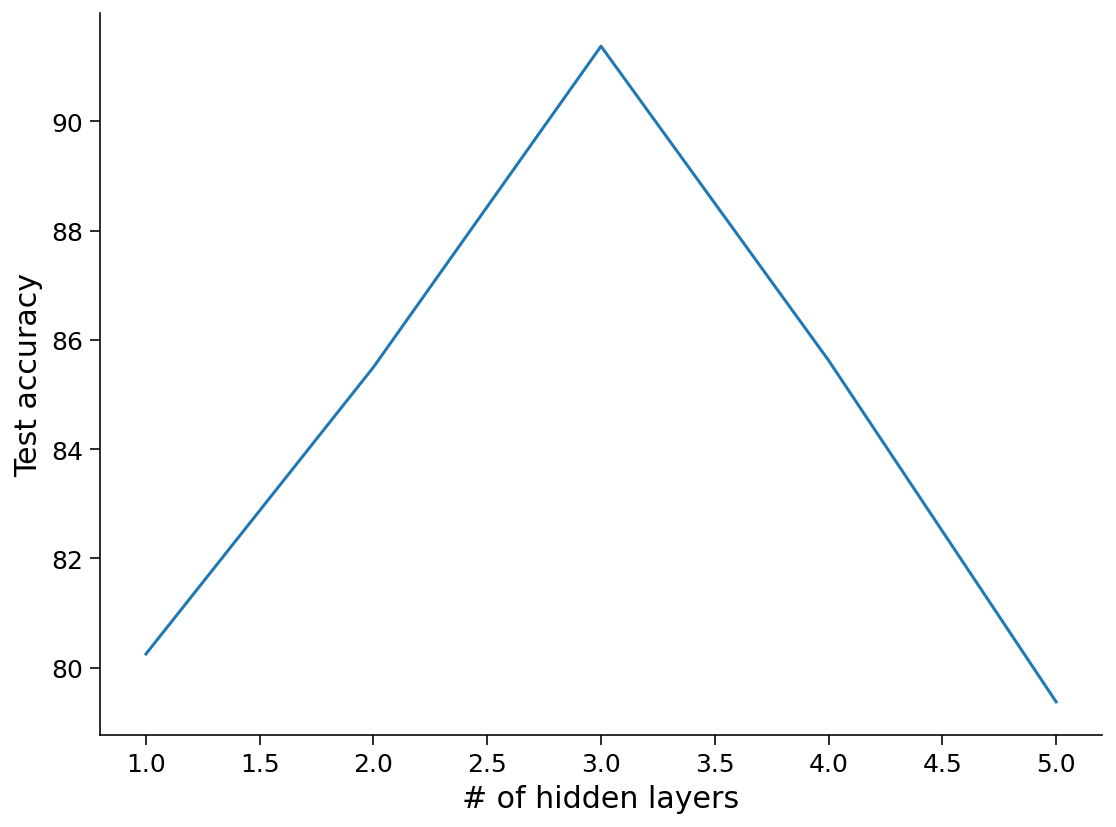

In [16]:
def run_depth_optimizer(max_par_count, max_hidden_layer, device):
  """
  Simulate Depth Optimizer

  Args:
    max_par_count: int
      Maximum number of hidden units in layer of depth optimizer
    max_hidden_layer: int
      Maximum number of hidden layers within depth optimizer
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    hidden_layers: int
      Number of hidden layers in depth optimizer
    test_scores: list
      Log of test scores
  """
  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  # raise NotImplementedError("Define the depth optimizer function")
  ###################################################################

  def count_parameters(model):
    """
    Function to count model parameters

    Args:
      model: instance of Net class
        MLP instance

    Returns:
      par_count: int
        Number of parameters in network
    """
    par_count = 0
    for p in model.parameters():
      if p.requires_grad:
        par_count += p.numel()
    return par_count

  # Number of hidden layers to try
  hidden_layers = torch.arange(1, max_hidden_layer + 1)

  # Test test score list
  test_scores = []

  for hidden_layer in hidden_layers:
    # Initialize the hidden units in each hidden layer to be 1
    hidden_units = np.ones(hidden_layer, dtype=np.int)

    # Define the the with hidden units equal to 1
    wide_net = Net('ReLU()', X_train.shape[1], hidden_units, K).to(device)
    par_count = count_parameters(wide_net)

    # Increment hidden_units and repeat until the par_count reaches the desired count
    while par_count < max_par_count:
      hidden_units += 1
      wide_net = Net('ReLU()', X_train.shape[1], hidden_units, K).to(device)
      par_count = count_parameters(wide_net)

    # Train it
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(wide_net.parameters(), lr=1e-3)
    _, test_acc = train_test_classification(wide_net, criterion, optimizer,
                                            train_loader, test_loader,
                                            num_epochs=100, device=device)
    test_scores += [test_acc]

  return hidden_layers, test_scores


# Add event to airtable
atform.add_event('Coding Exercise 1: Wide vs. Deep ')


set_seed(seed=SEED)
max_par_count = 100
max_hidden_layer = 5
## Uncomment below to test your function
hidden_layers, test_scores = run_depth_optimizer(max_par_count, max_hidden_layer, DEVICE)
plt.xlabel('# of hidden layers')
plt.ylabel('Test accuracy')
plt.plot(hidden_layers, test_scores)
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D3_MultiLayerPerceptrons/solutions/W1D3_Tutorial2_Solution_ee8656e9.py)

*Example output:*

<img alt='Solution hint' align='left' width=1120.0 height=832.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D3_MultiLayerPerceptrons/static/W1D3_Tutorial2_Solution_ee8656e9_12.png>



## Think! 1: Why the tradeoff?
Here we see that there is a particular number of hidden layers that is optimum. Why do you think increasing hidden layers after a certain point hurt in this scenario?

In [ ]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type answer here and Push submit',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D3_MultiLayerPerceptrons/solutions/W1D3_Tutorial2_Solution_bb717836.py)



## Section 1.1: Where Wide Fails
Let's use the same spiral dataset generated before with two features. And then add more polynomial features (which makes the first layer wider). And finally, train a single linear layer. We could use the same MLP network with no hidden layers (though it would not be called an MLP anymore!).

Note that we will add polynomial terms upto $P=50$ which means that for every $x_1^n x_2^m$ term, $n+m\leq P$. Now it's fun math exercise to prove why the total number of polynomial features upto $P$ becomes,
\begin{equation}
\text{# of terms} = \frac{(P+1)(P+2)}{2}
\end{equation}
Also, we don't need the polynomial term with degree zero (which is the constatnt term) since `nn.Linear` layers have bias terms. Therefore we will have one fewer polynomial feature.

Random seed 2021 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 69.88
Accuracy on the 800 testing samples: 72.62



/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


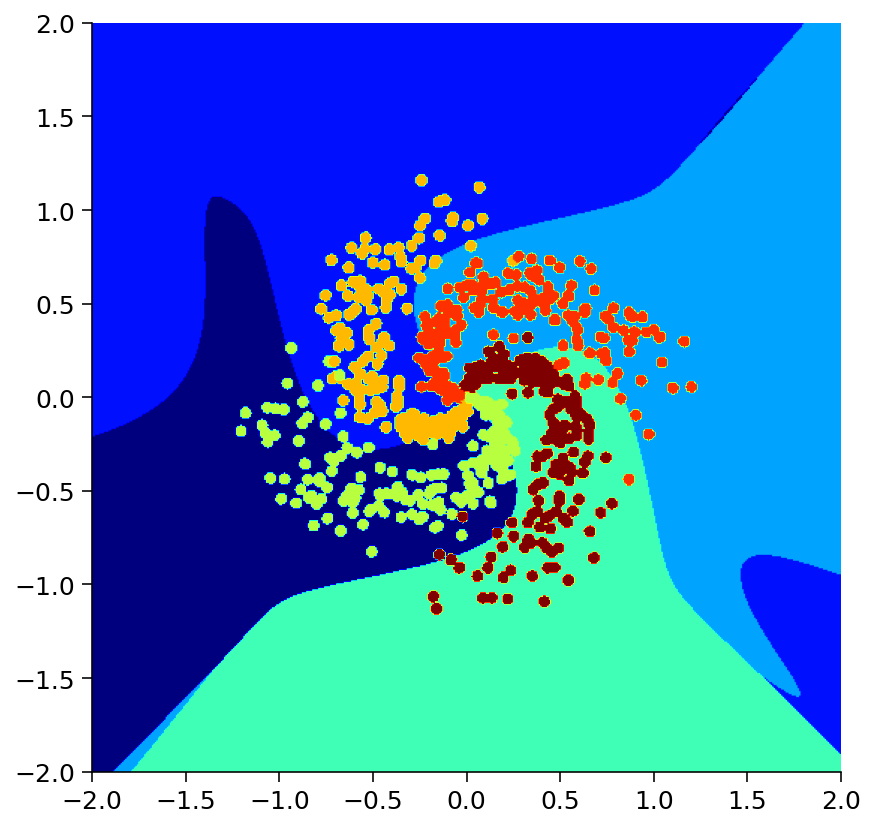

Number of features: 1325


In [17]:
def run_poly_classification(poly_degree, device='cpu', seed=0):
  """
  Helper function to run the above defined polynomial classifier

  Args:
    poly_degree: int
      Degree of the polynomial
    device: string
      CUDA/GPU if available, CPU otherwise
    seed: int
      A non-negative integer that defines the random state. Default is 0.

  Returns:
    num_features: int
      Number of features
  """

  def make_poly_features(poly_degree, X):
    """
    Function to define the number of polynomial features except the bias term

    Args:
      poly_degree: int
        Degree of the polynomial
      X: torch.tensor
        Input data

    Returns:
      num_features: int
        Number of features
      poly_X: torch.tensor
        Polynomial term
    """
    num_features = (poly_degree + 1)*(poly_degree + 2) // 2 - 1
    poly_X = torch.zeros((X.shape[0], num_features))
    count = 0
    for i in range(poly_degree+1):
      for j in range(poly_degree+1):
         # No need to add zero degree since model has biases
        if j + i > 0:
          if j + i <= poly_degree:
            # Define the polynomial term
            poly_X[:, count] = X[:, 0]**i * X [:, 1]**j
            count += 1
    return poly_X, num_features

  poly_X_test, num_features = make_poly_features(poly_degree, X_test)
  poly_X_train, _ = make_poly_features(poly_degree, X_train)

  batch_size = 128

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  poly_test_data = TensorDataset(poly_X_test, y_test)
  poly_test_loader = DataLoader(poly_test_data,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=1,
                                worker_init_fn=seed_worker,
                                generator=g_seed)

  poly_train_data = TensorDataset(poly_X_train, y_train)
  poly_train_loader = DataLoader(poly_train_data,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=1,
                                 worker_init_fn=seed_worker,
                                 generator=g_seed)

  # Define a linear model using MLP class
  poly_net = Net('ReLU()', num_features, [], K).to(device)

  # Train it!
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(poly_net.parameters(), lr=1e-3)
  _, _ = train_test_classification(poly_net, criterion, optimizer,
                                   poly_train_loader, poly_test_loader,
                                   num_epochs=100, device=DEVICE)
  # Test it
  X_all = sample_grid().to(device)
  poly_X_all, _ = make_poly_features(poly_degree, X_all)
  y_pred = poly_net(poly_X_all.to(device))

  # Plot it
  plot_decision_map(X_all.cpu(), y_pred.cpu(), X_test.cpu(), y_test.cpu())
  plt.show()

  return num_features


set_seed(seed=SEED)
max_poly_degree = 50
num_features = run_poly_classification(max_poly_degree, DEVICE, SEED)
print(f'Number of features: {num_features}')

### Think! 1.1: Does it generalize well?
Do you think this model is performing well outside its training distribution? Why?

In [ ]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q2', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D3_MultiLayerPerceptrons/solutions/W1D3_Tutorial2_Solution_9a2666ab.py)



---
# Section 2: Deeper MLPs

*Time estimate: ~55 mins*

In [18]:
# @title Video 2: Case study
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1FL411n7SH", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"3g_OJ6dYE8E", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 2: Case study')

display(out)

## Coding Exercise 2: Dataloader on a real-world dataset
Let's build our first real-world dataset loader with Data Preprocessing and Augmentation! And we will use the Torchvision transforms to do it.
We'd like to have a simple data augmentation with the following steps:
* Random rotation with $10$ degrees (`.RandomRotation`)
* Random horizontal flipping (`.RandomHorizontalFlip`)
and we'd like a preprocessing that:
* makes Pytorch tensors in the range $[0, 1]$ (`.ToTensor`)
* normalizes the input in the range $[-1, 1]$ (.`Normalize`)
<br>

**Hint:** For more info on transform, see the [official documentation](https://pytorch.org/vision/stable/transforms.html).

Random seed 2021 has been set.


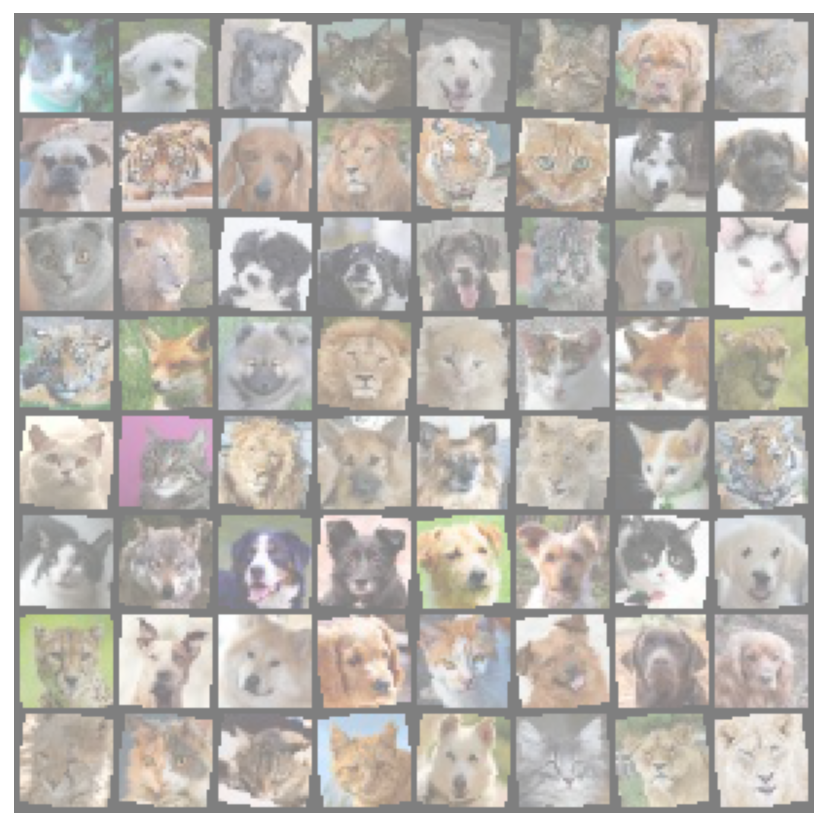

In [30]:
def get_data_loaders(batch_size, seed):
  """
  Helper function to get data loaders

  Args:
    batch_size: int
      Batch size
    seed: int
      A non-negative integer that defines the random state.

  Returns:
    img_train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    img_test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
  """
  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your function
  # raise NotImplementedError("Define the get data loaders function")
  ###################################################################

  # Define the transform done only during training
  augmentation_transforms = [transforms.RandomHorizontalFlip(10), transforms.RandomRotation(10)]

  # Define the transform done in training and testing (after augmentation)
  preprocessing_transforms = [transforms.ToTensor(), transforms.Normalize(0,1)]

  # Compose them together
  train_transform = transforms.Compose(augmentation_transforms + preprocessing_transforms)
  test_transform = transforms.Compose(preprocessing_transforms)

  # Using pathlib to be compatible with all OS's
  data_path = pathlib.Path('.')/'afhq'

  # Define the dataset objects (they can load one by one)
  img_train_dataset = ImageFolder(data_path/'train', transform=train_transform)
  img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  # Define the dataloader objects (they can load batch by batch)
  img_train_loader = DataLoader(img_train_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                worker_init_fn=seed_worker,
                                generator=g_seed)
  # num_workers can be set to higher if running on Colab Pro TPUs to speed up,
  # with more than one worker, it will do multithreading to queue batches
  img_test_loader = DataLoader(img_test_dataset,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=1,
                               worker_init_fn=seed_worker,
                               generator=g_seed)

  return img_train_loader, img_test_loader


# Add event to airtable
atform.add_event('Coding Exercise 2: Dataloader on a real-world dataset')


batch_size = 64
set_seed(seed=SEED)
## Uncomment below to test your function
img_train_loader, img_test_loader = get_data_loaders(batch_size, SEED)
## get some random training images
dataiter = iter(img_train_loader)
images, labels = dataiter.next()
## show images
imshow(make_grid(images, nrow=8))

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D3_MultiLayerPerceptrons/solutions/W1D3_Tutorial2_Solution_7712f9c3.py)

*Example output:*

<img alt='Solution hint' align='left' width=827.0 height=827.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D3_MultiLayerPerceptrons/static/W1D3_Tutorial2_Solution_7712f9c3_1.png>



In [31]:
# Train it
set_seed(seed=SEED)
net = Net('ReLU()', 3*32*32, [64, 64, 64], 3).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
_, _ = train_test_classification(net, criterion, optimizer,
                                img_train_loader, img_test_loader,
                                num_epochs=30, device=DEVICE)

Random seed 2021 has been set.


  0%|          | 0/30 [00:00<?, ?it/s]


Accuracy on the 14630 training samples: 87.07
Accuracy on the 1500 testing samples: 85.40



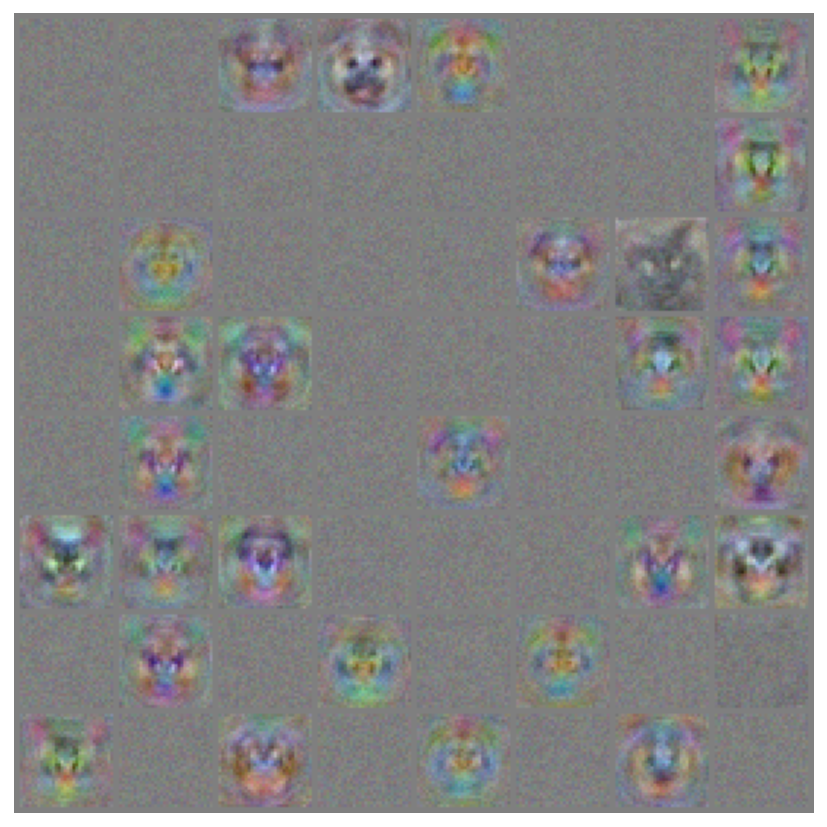

In [36]:
# Visualize the feature map
fc1_weights = net.mlp[0].weight.view(64, 3, 32, 32).detach().cpu()
fc1_weights /= torch.max(torch.abs(fc1_weights))
imshow(make_grid(fc1_weights, nrow=8))

## Think! 2: Why first layer features are high level?
Even though it's three layers deep, we see distinct animal faces in the first layer feature map. Do you think this MLP has a hierarchical feature representation? Why?

In [ ]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q3', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D3_MultiLayerPerceptrons/solutions/W1D3_Tutorial2_Solution_eb2e554f.py)



---
# Section 3: Ethical aspects

*Time estimate: ~20 mins*

In [38]:
# @title Video 3: Ethics: Hype in AI
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1CP4y1s712", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"ou35QzsKsdc", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 3: Ethics: Hype in AI')

display(out)

---
# Summary

In the second tutorial of this day, we have dived deeper into MLPs and seen more of their mathematical and practical aspects. More specifically, we have learned about different architectures, i.e., deep, wide, and how they are dependent on the transfer function used. Also, we have learned about the importance of initialization, and we mathematically analyzed two methods for smart initialization.

In [ ]:
# @title Video 4: Outro
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Kb4y1r76G", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"2sEPw4sSfSw", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 4: Outro')

display(out)

In [37]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/SurveyButton.png?raw=1"
 alt="button link end of day Survey" style="width:410px"></a>
   </div>""" )

---
# Bonus: The need for good initialization
In this section, we derive principles for initializing deep networks. We will see that if the weights are too large, then the forward propagation of signals will be chaotic, and the backpropagation of error gradients will explode. On the other hand, if the weights are too small, the forward propagation of signals will be ordered, and the backpropagation of error gradients will vanish. The key idea behind initialization is to choose the weights to be just right, i.e., at the edge between order and chaos. In this section, we derive this edge and show how to compute the correct initial variance of the weights. 

Many of the typical initialization schemes in existing deep learning frameworks implicitly employ this principle of initialization at the edge of chaos. So this section can be safely skipped on first pass and **is, hence, a bonus section**.

In [ ]:
# @title Video 5: Need for Good Initialization
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Qq4y1H7Px", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"W0V2kwHSuUI", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 5: Need for Good Initialization')

display(out)

## Xavier initialization
Let us look at the scale distribution of an output (e.g., a hidden variable)  $o_i$ for some fully-connected layer without nonlinearities. With $n_{in}$  inputs ($x_j$)  and their associated weights $w_{ij}$  for this layer. Then an output is given by,

\begin{equation}
  o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j
\end{equation}

The weights $w_{ij}$  are all drawn independently from the same distribution. Furthermore, let us assume that this distribution has zero mean and variance  $\sigma^2$. Note that this does not mean that the distribution has to be Gaussian, just that the mean and variance need to exist. For now, let us assume that the inputs to the layer  $x_j$ also have zero mean and variance  $\gamma^2$  and that they are independent of $w_{ij}$ and independent of each other. In this case, we can compute the mean and variance of $o_i$ as follows:


\begin{align}
  E[o_i] &= \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] \\ \\
  &= \sum_{j=1}^{n_\mathrm{in}} E[w_{ij}] E[x_j] = 0, \\ \\ \\
  \mathrm{Var}[o_i] &= E[o_i^2] - (E[o_i])^2 \\ \\
  &= \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij} x^2_j] - 0 \\ \\
  &= \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij}] E[x^2_j] \\ \\
  &= n_\mathrm{in} \sigma^2 \gamma^2
\end{align}

<br>

One way to keep the variance fixed is to set $n_{in}\sigma^2=1$ . Now consider backpropagation. There we face a similar problem, albeit with gradients being propagated from the layers closer to the output. Using the same reasoning as for forward propagation, we see that the gradients’ variance can blow up unless $n_{out}\sigma^2=1$ , where  $n_{out}$ is the number of outputs of this layer. This leaves us in a dilemma: we cannot possibly satisfy both conditions simultaneously. Instead, we simply try to satisfy:

\begin{align}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}
\end{align}

<br>

This is the reasoning underlying the now-standard and practically beneficial Xavier initialization, named after the first author of its creators [Glorot and Bengio, 2010](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). Typically, the Xavier initialization samples weights from a Gaussian distribution with zero mean and variance  $\sigma^2=\frac{2}{(n_{in}+n_{out})}$,


\begin{equation}
  w_{ij} \sim \mathcal{N} \left (\mu=0, \sigma=\sqrt{\frac{2}{(n_{in}+n_{out})}} \right)
\end{equation}


We can also adapt Xavier’s intuition to choose the variance when sampling weights from a uniform distribution. Note that the uniform distribution $\mathcal{U}(−a,a)$ has variance $\frac{a^2}{3}$. Plugging this into our condition on $\sigma^2$ yields the suggestion to initialize according to


\begin{equation}
w_{ij} \sim  \mathcal{U} \left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right)
\end{equation}


This explanation is mainly taken from [here](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html).

If you want to see more about initializations and their differences see [here](https://www.deeplearning.ai/ai-notes/initialization/).

## Initialization with transfer function
Let's derive the optimal gain for LeakyReLU following similar steps.

LeakyReLU is described mathematically:

\begin{equation}
f(x)=\left\{
  \begin{array}{ll}
    \alpha \cdot x & \text { for } x<0 \\
    x & \text { for } x \geq 0
  \end{array}\right.
\end{equation}

where $\alpha$ controls the angle of the negative slope.

Considering a single layer with this activation function gives,

\begin{align}
o_{i} &= \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j\\
z_{i} &= f\left( o_{i} \right)
\end{align}

where $z_i$ denotes the activation of node $i$.

The expectation of the output is still zero, i.e., $\mathbb{E}[f(o_i)=0]$, but the variance changes, and assuming that the probability $P(x < 0) = 0.5$, we have that:


\begin{align}
\mathrm{Var}[f(o_i)] &= \mathbb{E}[f(o_i)^2] - \left( \mathbb{E}[f(o_i)] \right)^{2} \\ \\
&= \frac{\mathrm{Var}[o_i] + \alpha^2 \mathrm{Var}[o_i]}{2} \\ \\
&= \frac{1+\alpha^2}{2}n_\mathrm{in} \sigma^2 \gamma^2
\end{align}

where $\gamma$ is the variance of the distribution of the inputs $x_j$ and $\sigma$ is the variance of the distribution of weights $w_{ij}$, as before.

Therefore, following the rest of derivation as before,

<br>

\begin{equation}
\sigma = gain\sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}, \, \text{where} \,\, gain = \sqrt{\frac{2}{1+\alpha^2}}
\end{equation}

As we can see from the derived formula of $\sigma$, the transfer function we choose is related with the variance of the distribution of the weights. As the negative slope of the LeakyReLU $\alpha$ becomes larger, the $gain$ becomes smaller and thus, the distribution of the weights is narrower. On the other hand, as $\alpha$ becomes smaller and smaller, the distribution of the weights is wider. Recall that, we initialize our weights, for example, by sampling from a normal distribution with zero mean and variance $\sigma^2$.

## Best gain for Xavier Initialization with Leaky ReLU
You're probably running out of time, so let me explain what's happening here. We derived a theoretical gain for initialization. But the question is whether it holds in practice? Here we have a setup to confirm our finding. We will try a range of gains and see the empirical optimum and whether it matches our theoretical value!

If you have time left, you can change the distribution to sample the initial weights from a uniform distribution. Comment out line 11 and uncomment line 12.

In [ ]:
N = 10  # Number of trials
gains = np.linspace(1/N, 3.0, N)
test_accs = []
train_accs = []
mode = 'uniform'
for gain in gains:
  print(f'\ngain: {gain}')

  def init_weights(m, mode='normal'):
    if type(m) == nn.Linear:
      torch.nn.init.xavier_normal_(m.weight, gain)
      # torch.nn.init.xavier_uniform_(m.weight, gain)

  negative_slope = 0.1
  actv = f'LeakyReLU({negative_slope})'
  set_seed(seed=SEED)
  net = Net(actv, 3*32*32, [128, 64, 32], 3).to(DEVICE)
  net.apply(init_weights)
  criterion = nn.CrossEntropyLoss()

  optimizer = optim.SGD(net.parameters(), lr=1e-2)
  train_acc, test_acc = train_test_classification(net, criterion, optimizer,
                                                  img_train_loader,
                                                  img_test_loader,
                                                  num_epochs=1,
                                                  verbose=True,
                                                  device=DEVICE)
  test_accs += [test_acc]
  train_accs += [train_acc]

best_gain = gains[np.argmax(train_accs)]
plt.plot(gains, test_accs, label='Test accuracy')
plt.plot(gains, train_accs, label='Train accuracy')
plt.scatter(best_gain, max(train_accs),
            label=f'best gain={best_gain:.1f}',
            c='k', marker ='x')

# Calculate and plot the theoretical gain
theoretical_gain = np.sqrt(2.0 / (1 + negative_slope ** 2))
plt.scatter(theoretical_gain, max(train_accs),
            label=f'theoretical gain={theoretical_gain:.2f}',
            c='g', marker ='x')
plt.legend()
plt.plot()